In [ ]:
!pip install pennylane
#!pip install pennylane-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 32.6 MB/s eta 0:00:00


In [ ]:

import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

In [ ]:
def vec_check(vec,electron_num):
    """
    To check solution conserve the charge
    """
    for i,e in enumerate(vec):
        if np.abs(e) > 1e-8:
            e_occ=bin(i)[2:]
            lst=' '.join(e_occ).split(' ')
            cv=tuple(map(int, lst))
            e_num=sum(cv)
            if e_num!=electron_num:
                return False
    return True

def exact_ch_energy_sz_0(num_electrons,symbol,geometry,charge):
    Ha=qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge,\
                                               basis="STO-3G",active_electrons=num_electrons)[0]
    H_matrix=qml.matrix(Ha)
    sz=qml.qchem.spinz(len(Ha.wires))
    SZ=qml.matrix(sz)
    vals, vecs = np.linalg.eigh(H_matrix+0.00001*SZ)

    inds=np.argsort(vals)
    eng=vals[inds]
    vec=vecs[:,inds]
    #E_collect=[0,0,0]
    E_collect=[eng[0]]
    print('The ground state energy with sz=0:',eng[0])


    #Stop=[False,False,False]

    elec_num=num_electrons
    k=0
    for i in range(1,len(eng)): # Finding first excited state with -1 Sz
        Sz=vec[:,i].dot(SZ.dot(np.transpose(np.conjugate(vec[:,i]))))
        if np.abs(Sz) < 1e-5 and vec_check(vec[:,i],elec_num):
            print('The first excied state energy with sz=0:',eng[i]-0.00001*Sz)
            #Stop[0]=True
            #E_collect[1]=eng[i]
            E_collect.append(eng[i]-0.00001*Sz)
            k+=1
        if k==2:
            break
    return E_collect


We use exact diagonalization to get the corresponding ground state and first excited state.

In [ ]:
r_lst=[0.5,1.0,1.5,2.0,2.5,3.0,3.5]
E_dict={}
E_0__lst=[]
E_1__lst=[]
E_2__lst=[]
#E_3=[]
for r in r_lst:
    a0=0.529177210903
    L=r/a0
    symbol=["H", "Li"]
    geometry=np.array([0.0, 0.0, -L/2, 0.0, 0.0, L/2])

    charge=0
    num_electrons=2
    E0,E1,E2=exact_ch_energy_sz_0(num_electrons,symbol,geometry,charge)
    E_0__lst.append(E0)
    E_1__lst.append(E1)
    E_2__lst.append(E2)
    #E_3.append(E3)

The ground state energy with sz=0: -7.047909872435885
The first excied state energy with sz=0: -7.0047253505073765
The first excied state energy with sz=0: -6.98655158630334
The ground state energy with sz=0: -7.784021324750156
The first excied state energy with sz=0: -7.658342766396849
The first excied state energy with sz=0: -7.643809651162728
The ground state energy with sz=0: -7.8821399725735946
The first excied state energy with sz=0: -7.759969497124919
The first excied state energy with sz=0: -7.743624936624291
The ground state energy with sz=0: -7.860828281841008
The first excied state energy with sz=0: -7.775551605885374
The first excied state energy with sz=0: -7.752282360954601
The ground state energy with sz=0: -7.823426970817585
The first excied state energy with sz=0: -7.777598560023309
The first excied state energy with sz=0: -7.741012762416147
The ground state energy with sz=0: -7.798504254068343
The first excied state energy with sz=0: -7.779419938527358
The first excie

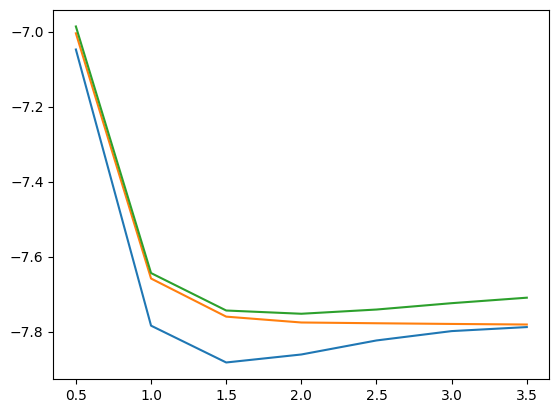

In [ ]:
plt.plot(r_lst,E_0__lst)
plt.plot(r_lst,E_1__lst)
plt.plot(r_lst,E_2__lst)
#plt.plot(r_lst,E_3)
#plt.plot(r_lst,E0_lst)

#plt.plot(r_lst,E1_lst)

# Subspace Search Variational Quantum Eigensolver

The the Subspace Search Variational Quantum Eigensolver (SSVQE) can obtain ground state and excied state at the same time. Its cost function is designed as

$C(\vec{\theta})=\sum_{i}w_{i}\left\langle \psi_{i}(\vec{\theta})\left|H\right|\psi_{i}(\vec{\theta_{i}})\right\rangle $

where $w_{i}\in[0,1]$. Usually, the lower states have larger weight and the weight of ground is set to 1. Besides, the initial trial state $\left|\psi_{i}\right\rangle$ should be orthogonal with each other.  

As the plot shown below, each qubit can be explained as whether the electrons occupy the spin orbitals. $1$ means the occupied orbital, while $0$ means empty orbital. Even (odd) sites mean spin up (down) orbital.(Plot from	Phys. Chem. Chem. Phys., 2021,23, 26438-26450)

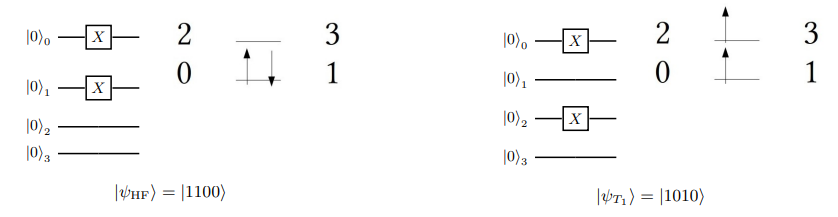

In [ ]:
def bit_to_vec(bitstring_dict,num_qubits):
    vec=np.zeros(2**num_qubits)
    amp=0
    for i in range(2**num_qubits):
        bitstr=bin(i)[2:]
        if len(bitstr) < num_qubits:
            bitstr=(num_qubits-len(bitstr))*'0'+bitstr

        if bitstr in bitstring_dict:
            vec[i]=bitstring_dict[bitstr]
            amp+=np.abs(bitstring_dict[bitstr])**2
    vec=vec/np.sqrt(amp)
    return vec

In [ ]:
class SS_vqe_ch():
    def __init__(self,state_lst,num_electrons,symbol,geometry,charge) -> None:
        """
        state_lst list(dict): The list of trial states for training the VQD

        For instance, you want to create |ψ_1>=1/√2|110000>+1/√2|001100>
        and |ψ_2>=1/√2|110000>-1/√2|001100> as the 6 qubits trial states

        state_psi_1={'110000':1,'001100':1}
        state_psi_2={'110000':1,'001100':-1}
        state_lst=[state_psi_1,state_psi_2]

        The length of bitstring is determined by the number of orbital. H3+ has 6 orbitals so the
        of bit string is 6.

        num_electrons (int): The number of electrons

        symbol list(str): The chemistry symbol (i.e. ["H","H"] for H2)

        geometry numpy array: The coodinates of the atoms in bohr

        charge int: the charge of the chemical molecules
        """
        self.num_electrons=num_electrons
        self.symbol=symbol
        self.geometry=geometry
        self.charge=charge

        self.hamiltonian=self.Ch_hamiltonian(symbol,geometry,num_electrons,charge)
        self.num_qubits = len(self.hamiltonian.wires)
        self.sz=qml.qchem.spinz(self.num_qubits)
        self.singles, self.doubles = qml.qchem.excitations(self.num_electrons, self.num_qubits)
        self.state_lst=[]
        for stat in state_lst:
            self.state_lst.append(bit_to_vec(stat,self.num_qubits))
        H_matrix=qml.matrix(self.hamiltonian)

        self.dev = qml.device("default.qubit", wires=self.num_qubits)
        self.cost_h_fn = qml.QNode(self.circuit, self.dev)
        self.Sz_fn = qml.QNode(self.circuit_sz, self.dev)

    def Ch_hamiltonian(self,symbol,geometry,num_electrons,charge):
        return qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge,\
                                               basis="STO-3G",active_electrons=num_electrons)[0]

    def hf(self,electrons, num_qubits):
        return qml.qchem.hf_state(electrons=electrons, orbitals=num_qubits)

    def circuit(self,state,weights):
        qml.StatePrep(state, wires=range(self.num_qubits))
        d_l=len(self.doubles)
        s_l=len(self.singles)
        for j in range(self.num_layer):
            for i in range(len(self.singles)):
                qml.SingleExcitation(weights[i+d_l+j*(d_l+s_l)], wires=self.singles[i])
            for i in range(len(self.doubles)):
                qml.DoubleExcitation(weights[i+j*(d_l+s_l)], wires=self.doubles[i])
        return qml.expval(self.hamiltonian)


    def circuit_sz(self,state,weights):
        qml.StatePrep(state, wires=range(self.num_qubits))
        d_l=len(self.doubles)
        s_l=len(self.singles)
        for j in range(self.num_layer):
            for i in range(len(self.singles)):
                qml.SingleExcitation(weights[i+d_l+j*(d_l+s_l)], wires=self.singles[i])
            for i in range(len(self.doubles)):
                qml.DoubleExcitation(weights[i+j*(d_l+s_l)], wires=self.doubles[i])
        return qml.expval(self.sz)

    def cost_fn(self,params):
        cost=0
        for ind, stat in enumerate(self.state_lst):
            cost+=self.w[ind]*self.cost_h_fn(stat,params)
        return cost

    def run(self,w=None,epochs=400,stepsize=0.5,num_layer=2,cov=1e-5,print_train=True):
        """
        w: the weight of each orthogonal state's cost function value.

        epochs: the iteration of training

        stepsize: the learning rate

        num_layer: the number of layer ansatz

        cov: if the difference between previous cost and current is samller than cov, the training will be stopped

        print_train: Whether you want to print the training process
        """
        if w==None:
            self.w=[1.0]+(len(self.state_lst)-1)*[0.5]
        else:
            self.w=w

        self.num_layer=num_layer
        opt = qml.AdamOptimizer(stepsize=stepsize)
        self.weights =np.zeros(num_layer*len(self.doubles + self.singles), requires_grad=True)

        i=0
        iter=[]
        cost_val=[]
        Lowest_cost=0
        self.best_weights=self.weights

        cov=cov
        E_pev=[0.0]*len(self.state_lst)
        E_lst=[0.0]*len(self.state_lst)
        E_pev=np.array(E_pev)
        E_lst=np.array(E_lst)
        for _ in range(epochs):
            self.weights = opt.step(self.cost_fn, self.weights)
            iter.append(i)
            cost=self.cost_fn(self.weights)
            for j,stat in enumerate(self.state_lst):
                E_lst[j]=self.cost_h_fn(stat,self.weights)

            if Lowest_cost>cost:
                Lowest_cost=cost
                self.best_weights=self.weights
            cost_val.append(E_lst)

            i=i+1
            if print_train:
                print('iter:',i)
                for j,stat in enumerate(self.state_lst):
                    print(' E0:',E_lst[j],' Sz:',self.Sz_fn(stat,self.weights))
            E_diff=np.abs(E_lst-E_pev)
            if np.all(E_diff<cov):
                break

            #for k in range(len(self.state_lst)):
            E_pev=E_lst.copy()
        self.E_lst=E_lst
        return E_lst

# For Sz=0, finding the three lowest energy using SS-VQE

In [ ]:
r_lst=[0.5,1.0,1.5,2.0,2.5,3.0,3.5] # the bond length in atomic unit
E_dict={}

E0_lst=[]
E1_lst=[]
E2_lst=[]

for r in r_lst:
    a0=0.529177210903
    L=r/a0
    symbol=["H", "Li"]
    geometry=np.array([0.0, 0.0, -L/2, 0.0, 0.0, L/2])

    charge=0
    num_electrons=2
    g_stat={'1100000000': 1} #We guess how ground state looks like

    ## We guess how the excited state with Sz=0 looks like
    e_stat_0={'1001000000': 1, '0110000000': -1}
    e_stat_1={'1001000000': 1, '0110000000': 1}

    stat_lst=[g_stat,e_stat_0,e_stat_1]
    ss_vqe=SS_vqe_ch(stat_lst,num_electrons,symbol,geometry,charge)
    print('Running '+str(r))
    E0,E1,E2=ss_vqe.run(epochs=400,num_layer=3)
    E0_lst.append(E0)
    E1_lst.append(E1)
    E2_lst.append(E2)


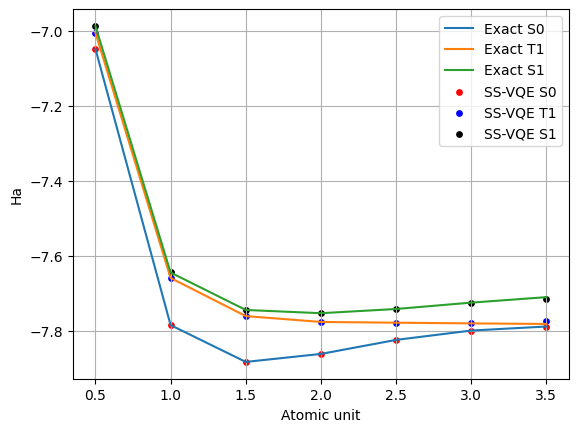

In [ ]:
plt.plot(r_lst,E_0__lst,label='Exact S0')
plt.plot(r_lst,E_1__lst,label='Exact T1')
plt.plot(r_lst,E_2__lst,label='Exact S1')

plt.scatter(r_lst,E0_lst,s=15,c='r',label='SS-VQE S0')
plt.scatter(r_lst,E2_lst,s=15,c='b',label='SS-VQE T1')
plt.scatter(r_lst,E1_lst,s=15,c='k',label='SS-VQE S1')

plt.xlabel('Atomic unit')
plt.ylabel('Ha')

plt.grid()
plt.legend()

In [ ]:
Rel0=np.abs(np.array(E_0__lst)-np.array(E0_lst))/np.abs(np.array(E_0__lst))
Rel1=np.abs(np.array(E_2__lst)-np.array(E2_lst))/np.abs(np.array(E_2__lst))
Rel2=np.abs(np.array(E_1__lst)-np.array(E1_lst))/np.abs(np.array(E_1__lst))

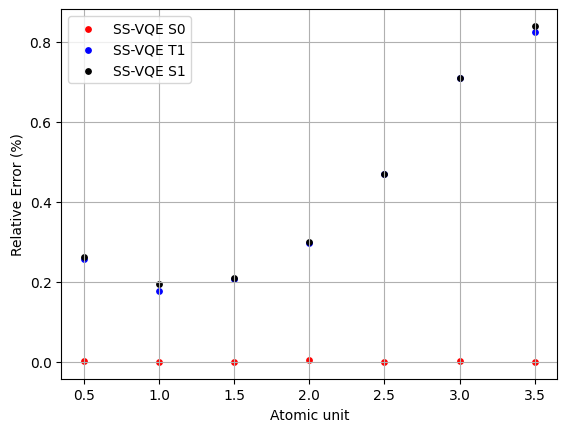

In [ ]:
plt.scatter(r_lst,Rel0*100,s=15,c='r',label='SS-VQE S0')
plt.scatter(r_lst,Rel1*100,s=15,c='b',label='SS-VQE T1')
plt.scatter(r_lst,Rel2*100,s=15,c='k',label='SS-VQE S1')

plt.xlabel('Atomic unit')
plt.ylabel('Relative Error (%)')

plt.grid()
plt.legend()

# For Sz=1, finding the three lowest energy using SS-VQE

In [ ]:
def exact_ch_energy_sz_1(num_electrons,symbol,geometry,charge):

    Ha=qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge,\
                                               basis="STO-3G",active_electrons=num_electrons)[0]
    H_matrix=qml.matrix(Ha)
    sz=qml.qchem.spinz(len(Ha.wires))
    SZ=qml.matrix(sz)
    vals, vecs = np.linalg.eigh(H_matrix+0.00001*SZ)

    inds=np.argsort(vals)
    eng=vals[inds]
    vec=vecs[:,inds]
    #E_collect=[0,0,0]
    E_collect=[eng[0]]
    print('The ground state energy with sz=0:',eng[0])

    #Stop=[False,False,False]

    elec_num=num_electrons
    k=0
    for i in range(1,len(eng)): # Finding first excited state with -1 Sz
        Sz=vec[:,i].dot(SZ.dot(np.transpose(np.conjugate(vec[:,i]))))
        if  np.abs(Sz.real-1)<1e-5 and vec_check(vec[:,i],elec_num):
            print('The energy state:',(eng[i]-0.00001*Sz).real,' with Sz=',round(Sz.real,3))

            E_collect.append((eng[i]-0.00001*Sz).real)
            k+=1
        if k==2:
            break

    return E_collect

In [ ]:
E_dict={}

E_0__lst=[]
E_1__lst=[]
E_2__lst=[]

for r in r_lst:
    a0=0.529177210903
    L=r/a0
    symbol=["H", "Li"]
    geometry=np.array([0.0, 0.0, -L/2, 0.0, 0.0, L/2])

    charge=0
    num_electrons=2
    E0,E1,E2=exact_ch_energy_sz_1(num_electrons,symbol,geometry,charge)

    E_0__lst.append(E0)
    E_1__lst.append(E1)
    E_2__lst.append(E2)

The ground state energy with sz=0: -7.047909872435877
The energy state: -7.00472535050736  with Sz= 1.0
The energy state: -6.9679100583105935  with Sz= 1.0
The ground state energy with sz=0: -7.7840213247501415
The energy state: -7.658342766396839  with Sz= 1.0
The energy state: -7.618067684104337  with Sz= 1.0
The ground state energy with sz=0: -7.882139972573577
The energy state: -7.759969497124903  with Sz= 1.0
The energy state: -7.712332320957347  with Sz= 1.0
The ground state energy with sz=0: -7.8608282818410204
The energy state: -7.775551605885385  with Sz= 1.0
The energy state: -7.716045218289305  with Sz= 1.0
The ground state energy with sz=0: -7.823426970817585
The energy state: -7.7775985600233035  with Sz= 1.0
The energy state: -7.707189769957235  with Sz= 1.0
The ground state energy with sz=0: -7.798504254068346
The energy state: -7.779419938527359  with Sz= 1.0
The energy state: -7.701092978024177  with Sz= 1.0
The ground state energy with sz=0: -7.790964266299491
The ene

In [ ]:
r_lst=[0.5,1.0,1.5,2.0,2.5,3.0,3.5] # the bond length in atomic unit
E_dict={}

E0_lst=[]
E1_lst=[]
#E2_lst=[]

for r in r_lst:
    a0=0.529177210903
    L=r/a0
    symbol=["H", "Li"]
    geometry=np.array([0.0, 0.0, -L/2, 0.0, 0.0, L/2])

    charge=0
    num_electrons=2
    g_stat={'1010000000': 1} ## We guess how the first excited state with Sz=1 looks like
    e_stat_0={'1000100000': 1} ## We guess how the second excited state with Sz=1 looks like

    stat_lst=[g_stat,e_stat_0]
    ss_vqe=SS_vqe_ch(stat_lst,num_electrons,symbol,geometry,charge)
    print('Running '+str(r))

    E0,E1=ss_vqe.run(epochs=400,num_layer=3)
    E0_lst.append(E0)
    E1_lst.append(E1)
    #E2_lst.append(E2)


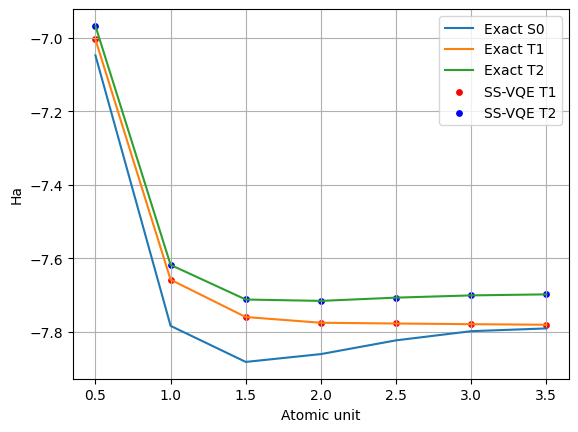

In [ ]:
plt.plot(r_lst,E_0__lst,label='Exact S0')
plt.plot(r_lst,E_1__lst,label='Exact T1')
plt.plot(r_lst,E_2__lst,label='Exact T2')

plt.scatter(r_lst,E0_lst,s=15,c='r',label='SS-VQE T1')
plt.scatter(r_lst,E1_lst,s=15,c='b',label='SS-VQE T2')
plt.xlabel('Atomic unit')
plt.ylabel('Ha')

plt.grid()
plt.legend()

In [ ]:
Rel0=np.abs(np.array(E_1__lst)-np.array(E0_lst))/np.abs(np.array(E_1__lst))
Rel1=np.abs(np.array(E_2__lst)-np.array(E1_lst))/np.abs(np.array(E_2__lst))


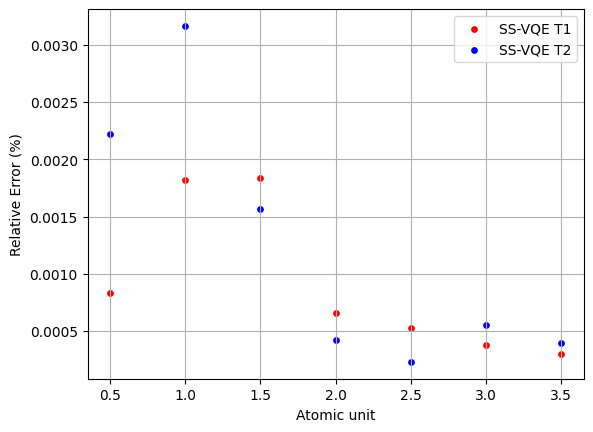

In [ ]:
plt.scatter(r_lst,Rel0*100,s=15,c='r',label='SS-VQE T1')
plt.scatter(r_lst,Rel1*100,s=15,c='b',label='SS-VQE T2')


plt.xlabel('Atomic unit')
plt.ylabel('Relative Error (%)')

plt.grid()
plt.legend()

In [ ]:
def bit_to_vec(bitstring_dict,num_qubits):
    vec=np.zeros(2**num_qubits)
    amp=0
    for i in range(2**num_qubits):
        bitstr=bin(i)[2:]
        if len(bitstr) < num_qubits:
            bitstr=(num_qubits-len(bitstr))*'0'+bitstr

        if bitstr in bitstring_dict:
            vec[i]=bitstring_dict[bitstr]
            amp+=np.abs(bitstring_dict[bitstr])**2
    vec=vec/np.sqrt(amp)
    return vec

In [ ]:
class adapt_SS_vqe_ch():
    def __init__(self,state_lst,num_electrons,symbol,geometry,charge) -> None:
        self.num_electrons=num_electrons
        self.symbol=symbol
        self.geometry=geometry
        self.charge=charge

        self.hamiltonian=self.Ch_hamiltonian(symbol,geometry,num_electrons,charge)
        self.num_qubits = len(self.hamiltonian.wires)
        self.sz=qml.qchem.spinz(self.num_qubits)
        self.singles, self.doubles = qml.qchem.excitations(self.num_electrons, self.num_qubits)
        self.state_lst=[]
        self.pool_operators=self.singles+self.doubles
        for stat in state_lst:
            self.state_lst.append(bit_to_vec(stat,self.num_qubits))

        self.dev = qml.device("default.qubit", wires=self.num_qubits)
        self.cost_h_fn = qml.QNode(self.circuit, self.dev)
        self.Sz_fn = qml.QNode(self.circuit_sz, self.dev)

    def Ch_hamiltonian(self,symbol,geometry,num_electrons,charge):
        return qml.qchem.molecular_hamiltonian(symbol, geometry, charge=charge,\
                                               basis="STO-3G",active_electrons=num_electrons)[0]

    def hf(self,electrons, num_qubits):
        return qml.qchem.hf_state(electrons=electrons, orbitals=num_qubits)

    def circuit(self,state,weights,ops_cir):
        qml.StatePrep(state, wires=range(self.num_qubits))
        for i, excitation in enumerate(ops_cir):
            if len(excitation) == 4:
                qml.DoubleExcitation(weights[i], wires=excitation)
            else:
                qml.SingleExcitation(weights[i], wires=excitation)
        return qml.expval(self.hamiltonian)

    def circuit_sz(self,state,weights,ops_cir):
        qml.StatePrep(state, wires=range(self.num_qubits))
        for i, excitation in enumerate(ops_cir):
            if len(excitation) == 4:
                qml.DoubleExcitation(weights[i], wires=excitation)
            else:
                qml.SingleExcitation(weights[i], wires=excitation)
        return qml.expval(self.sz)

    def cost_fn(self,params,ops_cir):
        cost=0
        for ind, stat in enumerate(self.state_lst):
            cost+=self.w[ind]*self.cost_h_fn(stat,params,ops_cir)
        return cost

    def run(self,w=None,epochs=400,stepsize=0.5,cov=1e-6,print_train=True,ep=30,threshold=0.03):
        if w==None:
            self.w=[1.0]+(len(self.state_lst)-1)*[0.5]
        else:
            self.w=w

        opt = qml.GradientDescentOptimizer(stepsize=stepsize)
        self.ops_cir=[]# doubles_select+singles_select
        weights = []
        self.weights=np.array(weights)

        circuit_gradient = qml.grad(self.cost_fn, argnum=0)
        for ind, stat in enumerate(self.state_lst):
            E0 = self.cost_h_fn(stat,self.weights, self.ops_cir)
            print(f"Epoch = 0, Energy = {E0:.8f} Ha")

        i=0
        iter=[]
        cost_val=[]
        Lowest_cost=0
        #self.best_weights=self.weights

        cov=cov
        E_pev=[0.0]*len(self.state_lst)
        E_lst=[0.0]*len(self.state_lst)
        E_pev=np.array(E_pev)
        E_lst=np.array(E_lst)
        for n in range(epochs):

            Test_set=self.ops_cir+self.pool_operators
            Test_params=list(self.weights)+[0.0]*len(self.pool_operators)
            Test_params=np.array(Test_params)

            test_grads = circuit_gradient(Test_params,Test_set)
            test_grads = test_grads[len(self.weights):]
            maxpos = np.argmax(np.abs(test_grads))
            print('Max:', np.abs(test_grads[maxpos]))
            #if n<= ep or np.abs(test_grads[maxpos])<threshold:

            max_op=self.pool_operators[maxpos]
            self.ops_cir.append(max_op)
            self.weights=np.append(self.weights, 0.0)

            self.weights,_ = opt.step(self.cost_fn,self.weights,self.ops_cir)
            iter.append(i)
            cost=self.cost_fn(self.weights,self.ops_cir)
            for j,stat in enumerate(self.state_lst):
                E_lst[j]=self.cost_h_fn(stat,self.weights,self.ops_cir)

            if Lowest_cost>cost:
                Lowest_cost=cost
                self.best_weights=self.weights
            cost_val.append(E_lst)

            i=i+1
            if print_train:
                print('iter:',i)
                for j,stat in enumerate(self.state_lst):
                    print(' E0:',E_lst[j],' Sz:',self.Sz_fn(stat,self.weights,self.ops_cir))
            E_diff=np.abs(E_lst-E_pev)
            if np.all(E_diff<cov):
                break

            #for k in range(len(self.state_lst)):
            E_pev=E_lst.copy()
        self.E_lst=E_lst
        return E_lst